In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import plotting_funcs as plot_func
import util

### Reading in data

In [2]:
# A full week we know the ISP was running epping
epping_period = ("2024-04-22T00:00-06:00", "2024-04-29T00:00-06:00")

# A full week we know the ISP wasn't running epping
baseline_period = ("2024-05-06T00:00-06:00", "2024-05-13T00:00-06:00")

In [3]:
cpu = pd.read_csv("data/overhead_measurements/InfluxDB_CPU_20240413-20240513.csv", header=3, 
                   usecols=["_time", "_value", "_field"])

cpu["_time"] = pd.to_datetime(cpu["_time"]).dt.tz_convert("US/Mountain")
cpu.rename(columns={"_time": "time", "_value": "value", "_field": "cpu"}, inplace=True)

avg_cpu = cpu.groupby("time")["value"].mean()
cpu = pd.concat([cpu, pd.DataFrame({"time": avg_cpu.index, 
                                    "value": avg_cpu.values, "cpu": "avg"})])
cpu

,time,value,cpu
0,2024-04-13 10:00:00-06:00,25.200643,CPU_0
1,2024-04-13 11:00:00-06:00,23.622778,CPU_0
2,2024-04-13 12:00:00-06:00,22.578056,CPU_0
3,2024-04-13 13:00:00-06:00,23.131111,CPU_0
4,2024-04-13 14:00:00-06:00,23.788611,CPU_0
...,...,...,...
637,2024-05-13 06:00:00-06:00,11.211391,avg
638,2024-05-13 07:00:00-06:00,13.077428,avg
639,2024-05-13 08:00:00-06:00,14.495938,avg
640,2024-05-13 09:00:00-06:00,14.694981,avg


In [4]:
epping_cpu = cpu.query("cpu == 'avg' and time >= @epping_period[0] and time < @epping_period[1]")
epping_cpu.describe()

,value
count,168.000000
mean,17.403880
std,5.048806
min,7.132269
25%,13.693970
50%,17.330093
75%,21.595949
max,29.373889


In [5]:
baseline_cpu = cpu.query("cpu == 'avg' and time >= @baseline_period[0] and time < @baseline_period[1]")
baseline_cpu.describe()

,value
count,168.000000
mean,16.094741
std,4.719204
min,6.147899
25%,12.348599
50%,15.518651
75%,20.056822
max,28.555392


In [6]:
traffic = pd.read_csv("data/overhead_measurements/jackrabbit-shaper-per_day-20240421-20240513.csv")
traffic.rename(columns={"tick": "time"}, inplace=True)
traffic["time"] = pd.to_datetime(traffic["time"]).dt.tz_convert("US/Mountain")
traffic["tot_kpps"] = (traffic["packets_down_avg"] + traffic["packets_up_avg"]) / 1e3

In [7]:
epping_traffic = traffic.query("time >= @epping_period[0] and time < @epping_period[1]")
epping_traffic.describe()

,org_key,shaper_key,packets_down_min,packets_down_max,packets_down_avg,packets_up_min,packets_up_max,packets_up_avg,bits_down_min,bits_down_max,bits_down_avg,bits_up_min,bits_up_max,bits_up_avg,tot_kpps
count,210.0,210.0,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,2.100000e+02,2.100000e+02,2.100000e+02,2.100000e+02,2.100000e+02,2.100000e+02,210.000000
mean,2.0,2.0,54730.647619,139058.914286,90117.878472,29047.395238,71186.771429,45593.212202,5.312226e+08,1.491983e+09,9.329416e+08,6.986702e+07,2.111238e+08,1.147827e+08,135.711091
std,0.0,0.0,28948.952879,45347.782414,38146.766892,13708.324886,25764.810552,19421.153457,3.126289e+08,5.029496e+08,4.201006e+08,2.650688e+07,4.833833e+07,3.288895e+07,57.472830
min,2.0,2.0,13300.000000,54920.000000,30514.458333,9437.000000,29286.000000,16552.833333,1.046687e+08,5.653946e+08,2.806116e+08,2.304502e+07,1.007347e+08,4.472824e+07,47.096063
25%,2.0,2.0,33158.750000,105906.500000,62007.036458,17524.500000,50639.500000,30193.869792,2.884757e+08,1.119743e+09,6.349762e+08,4.900242e+07,1.785142e+08,9.424385e+07,92.474911
50%,2.0,2.0,45716.000000,127826.000000,78095.625000,25878.500000,65119.000000,40215.531250,4.254406e+08,1.362477e+09,7.870622e+08,6.729059e+07,2.143511e+08,1.146242e+08,118.012854
75%,2.0,2.0,77586.000000,177331.000000,123205.312500,39248.000000,90685.750000,62753.697917,7.798910e+08,1.902305e+09,1.291088e+09,9.395821e+07,2.358915e+08,1.436103e+08,185.819646
max,2.0,2.0,125712.000000,237543.000000,178752.562500,64647.000000,135245.000000,93082.875000,1.332699e+09,2.597699e+09,1.927845e+09,1.209518e+08,4.072834e+08,1.768291e+08,271.835438


In [8]:
baseline_traffic = traffic.query("time >= @baseline_period[0] and time < @baseline_period[1]")
baseline_traffic.describe()

,org_key,shaper_key,packets_down_min,packets_down_max,packets_down_avg,packets_up_min,packets_up_max,packets_up_avg,bits_down_min,bits_down_max,bits_down_avg,bits_up_min,bits_up_max,bits_up_avg,tot_kpps
count,210.0,210.0,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,2.100000e+02,2.100000e+02,2.100000e+02,2.100000e+02,2.100000e+02,2.100000e+02,210.000000
mean,2.0,2.0,49139.957143,134111.009524,83077.592460,26027.009524,69119.500000,41455.478770,4.733024e+08,1.441323e+09,8.565208e+08,6.816568e+07,2.298889e+08,1.151688e+08,124.533071
std,0.0,0.0,26064.521360,45280.485838,34504.725352,12126.343807,28949.383787,17169.777387,2.811712e+08,5.106374e+08,3.783004e+08,2.509810e+07,1.017878e+08,3.270888e+07,51.602586
min,2.0,2.0,12255.000000,61757.000000,31017.083333,7589.000000,27749.000000,14133.020833,8.894858e+07,6.204655e+08,2.920852e+08,1.741214e+07,9.034022e+07,4.076042e+07,45.766083
25%,2.0,2.0,29722.750000,99715.000000,57773.572917,16108.250000,48084.750000,28247.744792,2.647635e+08,1.059234e+09,5.651730e+08,4.741149e+07,1.840864e+08,9.121419e+07,86.126104
50%,2.0,2.0,42068.000000,126739.500000,73888.395833,23493.000000,62377.500000,38214.885417,3.976967e+08,1.355909e+09,7.533201e+08,6.808921e+07,2.159000e+08,1.191033e+08,111.378062
75%,2.0,2.0,70682.000000,169503.000000,113451.505208,35866.000000,87439.000000,55793.916667,6.978263e+08,1.839758e+09,1.192066e+09,8.983519e+07,2.484216e+08,1.419425e+08,168.924948
max,2.0,2.0,129720.000000,332330.000000,179537.333333,62920.000000,233483.000000,91569.458333,1.385056e+09,3.815253e+09,1.941556e+09,1.205365e+08,1.030773e+09,1.768593e+08,271.106792


### CPU and packet rate distributions

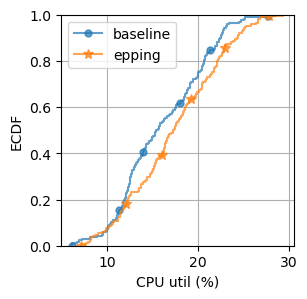

In [9]:
fig, axes = plt.subplots(figsize=(3, 3))
plot_func.plot_ecdf(*util.ecdf(baseline_cpu["value"]), axes=axes, alpha=0.7,
                    label="baseline", marker="o", markersize=5, markevery=0.2)
plot_func.plot_ecdf(*util.ecdf(epping_cpu["value"]), axes=axes, alpha=0.7,
                    label="epping", marker="*", markersize=7, markevery=0.2)

axes.set_ylim(0, 1)
axes.set_ylabel("ECDF")
axes.set_xlabel("CPU util (%)")
axes.grid()
axes.legend()
fig.savefig("figures/overhead_cpu_util.pdf", bbox_inches="tight")

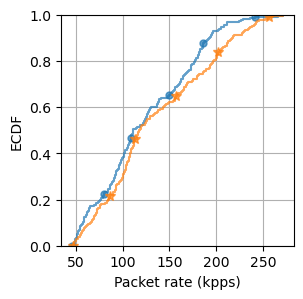

In [10]:
fig, axes = plt.subplots(figsize=(3, 3))
plot_func.plot_ecdf(*util.ecdf(baseline_traffic["tot_kpps"]), axes=axes, alpha=0.7,
                    label="baseline", marker="o", markersize=5, markevery=0.2)
plot_func.plot_ecdf(*util.ecdf(epping_traffic["tot_kpps"]), axes=axes, alpha=0.7,
                    label="epping", marker="*", markersize=7, markevery=0.2)

axes.set_ylim(0, 1)
axes.set_ylabel("ECDF")
axes.set_xlabel("Packet rate (kpps)")
axes.grid()
#axes.legend()
fig.savefig("figures/overhead_kpps.pdf", bbox_inches="tight")

### An attempt at trying to normalize CPU utilization against packet-load

In [11]:
epping_cpu["value"].mean() / epping_traffic["tot_kpps"].mean()

0.1282421313754667

In [12]:
baseline_cpu["value"].mean() / baseline_traffic["tot_kpps"].mean()

0.12924070088792589

In [13]:
epping_cpu_norm = (epping_cpu.resample("1h", on="time")["value"].mean() / 
                   epping_traffic.resample("1h", on="time")["tot_kpps"].mean())
epping_cpu_norm.describe()

count    168.000000
mean       0.140636
std        0.043331
min        0.077462
25%        0.106494
50%        0.127403
75%        0.164963
max        0.282075
dtype: float64

In [14]:
baseline_cpu_norm = (baseline_cpu.resample("1h", on="time")["value"].mean() / 
                     baseline_traffic.resample("1h", on="time")["tot_kpps"].mean())
baseline_cpu_norm.describe()

count    168.000000
mean       0.141836
std        0.044443
min        0.083741
25%        0.113252
50%        0.125568
75%        0.164141
max        0.299439
dtype: float64

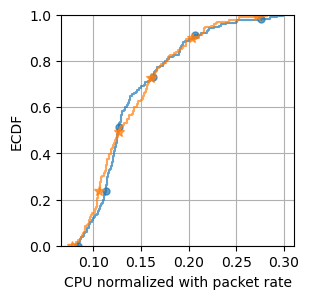

In [15]:
fig, axes = plt.subplots(figsize=(3, 3))
plot_func.plot_ecdf(*util.ecdf(baseline_cpu_norm), axes=axes, alpha=0.7,
                    label="baseline", marker="o", markersize=5, markevery=0.2)
plot_func.plot_ecdf(*util.ecdf(epping_cpu_norm), axes=axes, alpha=0.7,
                    label="epping", marker="*", markersize=7, markevery=0.2)

axes.set_ylim(0, 1)
axes.set_ylabel("ECDF")
axes.set_xlabel("CPU normalized with packet rate")
axes.grid()
#axes.legend()
fig.savefig("figures/overhead_cpu_norm.pdf", bbox_inches="tight")

### eBPF program runtime

In [16]:
def parse_bpf_proglist_output(bpf_str, verbose=False):
    progs = list()
    
    for line in bpf_str.splitlines():

        words = line.split()
        if len(words) < 6:
            continue
        if not re.match("^\d+:", line):
            continue

        bpf_id = int(words[0].rstrip(":"))

        name = None
        runtime = 0
        count = 0
        for i, word in enumerate(words):
            if word == "name":
                name = words[i + 1]
            if word == "run_time_ns":
                runtime = int(words[i + 1])
            if word == "run_cnt":
                count = int(words[i + 1])

        if (runtime > 0 and count > 0):
            progs.append({"id": bpf_id, "name": name, 
                          "count": count, "cum_time_ns": runtime,
                          "avg_time_ns": runtime / count})
        
            if verbose:
                print("id: {}, name: {}, count: {}, average runtime: {:.2f} ns".format(
                    bpf_id, name, count, runtime / count))
    
    return progs

In [17]:
with open("data/overhead_measurements/proglistoutput_after_enabling_bpf_stats_24hr.txt") as infile:
    bpf_progs = parse_bpf_proglist_output(infile.read(), verbose=True)

id: 328, name: xdp_prog, count: 10838840606, average runtime: 649.35 ns
id: 330, name: tc_iphash_to_cpu, count: 5399454647, average runtime: 51.59 ns
id: 331, name: bifrost, count: 10838840124, average runtime: 54.23 ns
id: 332, name: throughput_reader, count: 7989687383, average runtime: 366.03 ns
id: 333, name: flow_reader, count: 2405781608, average runtime: 144.11 ns
id: 335, name: xdp_prog, count: 5399454800, average runtime: 735.32 ns
id: 336, name: tc_iphash_to_cpu, count: 10838840160, average runtime: 48.64 ns
id: 337, name: bifrost, count: 5399454617, average runtime: 68.91 ns
id: 368, name: pping_tc_egress, count: 5399454652, average runtime: 324.93 ns
id: 370, name: pping_tc_ingress, count: 10838840131, average runtime: 268.84 ns
id: 371, name: tsmap_cleanup, count: 248759894, average runtime: 408.37 ns
id: 372, name: flowmap_cleanup, count: 1884270509, average runtime: 198.97 ns


In [18]:
sel_progs = ["pping_tc_ingress", "pping_tc_egress", "tsmap_cleanup", "flowmap_cleanup"]
pping_progs = {prog["name"]: prog for prog in bpf_progs if prog["name"] in sel_progs}
pping_progs

{'pping_tc_egress': {'id': 368,
  'name': 'pping_tc_egress',
  'count': 5399454652,
  'cum_time_ns': 1754452628955,
  'avg_time_ns': 324.931449939141},
 'pping_tc_ingress': {'id': 370,
  'name': 'pping_tc_ingress',
  'count': 10838840131,
  'cum_time_ns': 2913926833291,
  'avg_time_ns': 268.84120423152314},
 'tsmap_cleanup': {'id': 371,
  'name': 'tsmap_cleanup',
  'count': 248759894,
  'cum_time_ns': 101586582029,
  'avg_time_ns': 408.3720265172649},
 'flowmap_cleanup': {'id': 372,
  'name': 'flowmap_cleanup',
  'count': 1884270509,
  'cum_time_ns': 374916527296,
  'avg_time_ns': 198.97171107081206}}

In [19]:
print("Average runtime for each pping prog per invocation")
for prog in pping_progs.values():
    print("  {}: {:.2f} ns ({:.2f}M invocations)".format(
        prog["name"], prog["avg_time_ns"], prog["count"] / 1e6))

Average runtime for each pping prog per invocation
  pping_tc_egress: 324.93 ns (5399.45M invocations)
  pping_tc_ingress: 268.84 ns (10838.84M invocations)
  tsmap_cleanup: 408.37 ns (248.76M invocations)
  flowmap_cleanup: 198.97 ns (1884.27M invocations)


In [20]:
tot_time = sum([prog["cum_time_ns"] for prog in pping_progs.values()])

print("Fraction of overall time used by the different eBPF programs:")
for prog_name, prog in pping_progs.items():
    print("  {}: {:.3%} ({:.1f}s / {:.1f}s)".format(
        prog_name, prog["cum_time_ns"] / tot_time, prog["cum_time_ns"] / 1e9, tot_time / 1e9))

Fraction of overall time used by the different eBPF programs:
  pping_tc_egress: 34.101% (1754.5s / 5144.9s)
  pping_tc_ingress: 56.637% (2913.9s / 5144.9s)
  tsmap_cleanup: 1.975% (101.6s / 5144.9s)
  flowmap_cleanup: 7.287% (374.9s / 5144.9s)


In [21]:
pping_rx = pping_progs["pping_tc_ingress"]
pping_tx = pping_progs["pping_tc_egress"]

In [22]:
print("Ingress ran {:.2f} as often as egress".format(pping_rx["count"] / pping_tx["count"]))
print("Ingress had {:.2%} lower per-packet overhead than egress ({:.2f}ns vs {:.2f}ns)".format(
    1 - pping_rx["avg_time_ns"] / pping_tx["avg_time_ns"], pping_rx["avg_time_ns"], pping_tx["avg_time_ns"]))

Ingress ran 2.01 as often as egress
Ingress had 17.26% lower per-packet overhead than egress (268.84ns vs 324.93ns)


In [23]:
packet_process_avg = (pping_rx["cum_time_ns"] + pping_tx["cum_time_ns"]) / (pping_rx["count"] + pping_tx["count"])

print("Weighted mean of per-packet overhead {:.3f} ns".format(packet_process_avg))

Weighted mean of per-packet overhead 287.492 ns


In [24]:
single_cpu_util = (packet_process_avg * epping_traffic["tot_kpps"].mean()) * 1e3 / 1e9
print("Packet process overhead at avg packet rate: {:.3%} ({:.3%} across 6 cores)".format(
    single_cpu_util, single_cpu_util/6))

Packet process overhead at avg packet rate: 3.902% (0.650% across 6 cores)
